Tegmark: How to make CMB maps? https://arxiv.org/pdf/astro-ph/9611130.pdf

The observed antenna temperature $T_A$ at a frequency $\nu$ is the convolution between the sky brightness temperature $T_b$ and the primary antenna beam $A_p$:

$$T_A(\nu) = \int \mathrm{d}\Omega A_p(\nu, \Omega) T_b(\nu, \Omega)$$

Our goal is to recover the sky brightness temperature as a function of position and frequency, i.e. making maps. 

We start by rewriting the convolution in terms of a dot product between spherical harmonics coefficients following e.g. [this derivation](https://github.com/christianhbye/croissant/blob/main/docs/math.md):

$$A_p(\Omega) = \sum_{\ell, m} a_\ell^m Y_{\ell}^m,\, T_b (\Omega) = \sum_{\ell, m} b_\ell^m Y_{\ell}^m \\
T_A = \sum_{\ell, m} a_\ell^m (b_\ell^m)^* $$

This lets us rephrase the problem with linear algebra:

$$\mathbf{y} = \mathbf{A}\mathbf{x} + \mathbf{n},$$

where for any given frequency $\mathbf{y}$ is the observed data (the antenna temperature), $\mathbf{x}$ is a vector containing the coefficients of the sky spherical harmonics expansion, $\mathbf{n}$ is the noise, and $\mathbf{A}$ is a matrix of the spherical harmonics coefficients of the antenna beam..

Following Tegmark 1996, we use Wiener filtering to estimate $\mathbf{x}$ (which we denote by $\mathbf{\tilde{x}}$):

$$\mathbf{\tilde{x}} = \mathbf{W} \mathbf{y} \\
\mathbf{W} = \left[\mathbf{S}^{-1} + \mathbf{A^t} \mathbf{N}^{-1} \mathbf{A} \right]^{-1} \mathbf{A^t} \mathbf{N}^{−1} \textrm{(Wiener Filtering)} \\
\mathbf{W} = \left[\mathbf{A^t} \mathbf{N}^{-1} \mathbf{A} \right]^{-1} \mathbf{A^t} \mathbf{N}^{−1} \textrm{(Least Squares)} \\ 
\mathbf{W} = \left[\mathbf{N}^{-1/2} \mathbf{A} \right]^{+} \mathbf{N}^{−1/2} \textrm{(Unmeasured Modes)} $$

In [1]:
import croissant as cro
import healpy as hp
import matplotlib.pyplot as plt
import numpy as np

fatal: No names found, cannot describe anything.


In [2]:
NSIDE = 128
NPIX = 12 * NSIDE **2
moon = True  # on moon or earth
lmax = 75
ndays = 1
ntimes = 700
FREQ = 50  # MHz

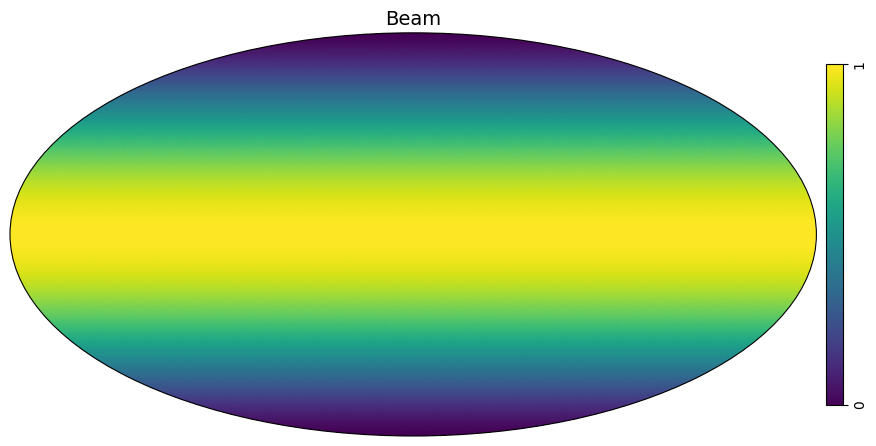

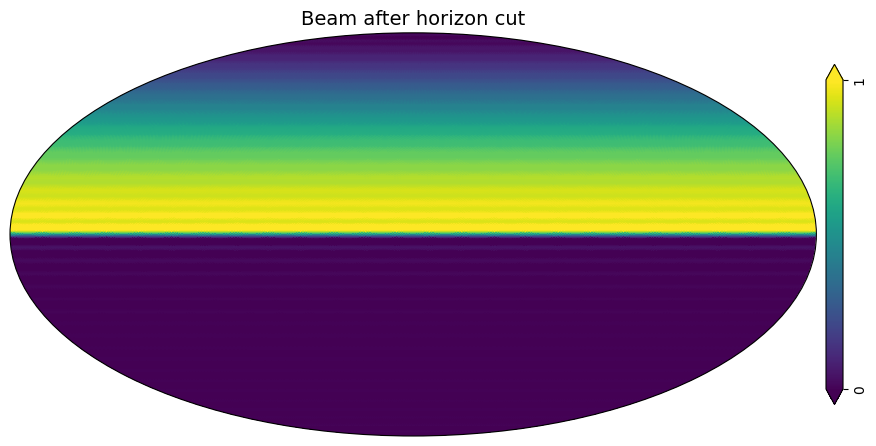

In [3]:
alm = np.zeros(hp.Alm.getsize(lmax))
beam = cro.Beam(alm, lmax=lmax, coord="T", frequencies=FREQ)
beam[0, 0] = 4/3 * np.sqrt(np.pi)
#beam[1, 0] = np.sqrt(np.pi / 3)
beam[2, 0] = - 4/3 * np.sqrt(np.pi / 5) #- np.sqrt(np.pi / 3)

hp.projview(beam.hp_map(NSIDE), cbar=True, title="Beam", cb_orientation="vertical", min=0, max=1)
plt.show()

horizon = np.ones(NPIX)
theta = hp.pix2ang(NSIDE, np.arange(NPIX))[0]
horizon[theta > np.pi / 2] = 0
beam.horizon_cut(horizon=horizon)
hp.projview(beam.hp_map(NSIDE), cbar=True, title="Beam after horizon cut", cb_orientation="vertical", min=0, max=1)
plt.show()

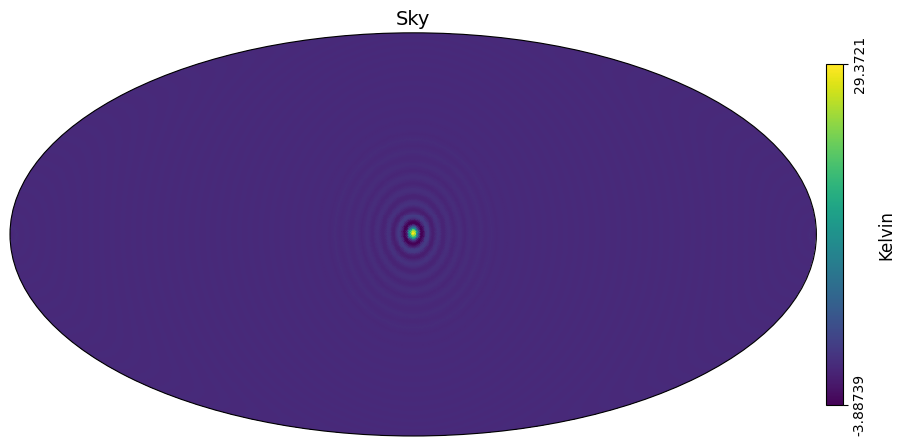

In [4]:
# point source at equator
smap = np.zeros(NPIX)
src_ix = hp.ang2pix(NSIDE, 0, 0, lonlat=True)
smap[src_ix] = 1000
hp_sky = cro.healpix.HealpixMap(smap, frequencies=beam.frequencies, coord="C")
sky = cro.Sky.from_healpix(hp_sky, lmax=lmax)

hp.projview(sky.hp_map(NSIDE), cbar=True, title="Sky", cb_orientation="vertical", unit="Kelvin")
plt.show()

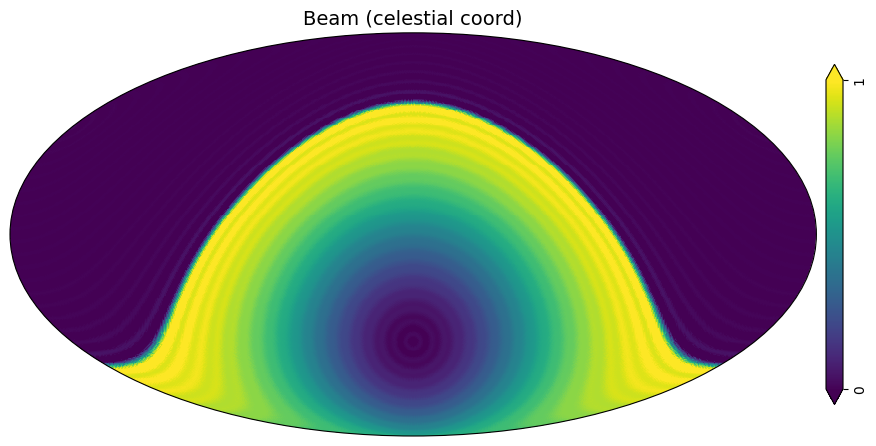

In [5]:
from lunarsky import Time
from astropy.units import s

location = (0, -40) # lon, lat
t_start = Time("2023-02-28 16:31")
delta_t = ndays / ntimes
# convert delta t to seconds
if moon:
    delta_t *= cro.constants.sidereal_day_moon * s
else:
    delta_t *= cro.constants.sidereal_day_earth * s

times = cro.simulator.time_array(t_start=t_start, N_times=ntimes, delta_t=delta_t)

if moon:
    world = "moon"
else:
    world = "earth"

sim = cro.Simulator(beam, sky, lmax=lmax, world=world, location=location, times=times)

hp.projview(sim.beam.hp_map(NSIDE), cbar=True, title="Beam (celestial coord)", cb_orientation="vertical", min=0, max=1)
plt.show()

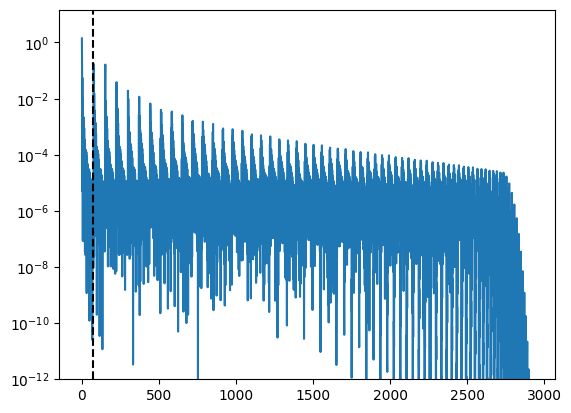

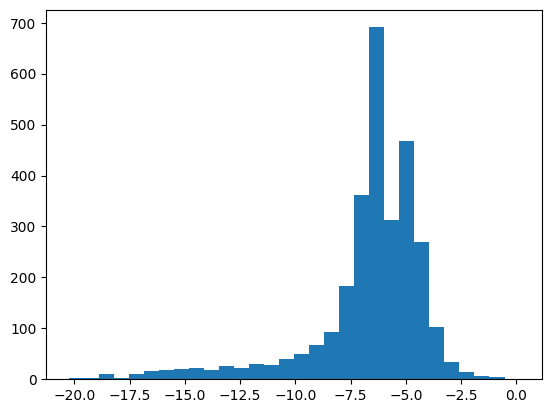

In [6]:
plt.figure()
plt.plot(np.abs(sim.beam.alm)**2)#, marker="o")
#plt.xticks(ticks=np.arange(hp.Alm.getsize(lmax)), labels=list(zip(*hp.Alm.getlm(lmax))))
plt.yscale("log")
plt.axvline(sim.lmax, ls="--", c="k")
plt.ylim(1e-12)
#plt.xlim(-1, 155)
plt.show()

plt.figure()
plt.hist(np.log10(np.abs(sim.beam.alm)**2), bins=30)
plt.show()

In [7]:
def all_alm(hp_alm, lmax=lmax):
    """
    Append negative m indices to alm array (these are -1^m * conjugate(positive alm) for m > 0)
    """
    sign = (-1) ** hp.Alm.getlm(lmax)[1][lmax+1:]  # -1^m for m > 0
    return np.concatenate((hp_alm, sign * np.conj(hp_alm[..., lmax+1:])), axis=-1)

def hp_alm(all_alm, lmax=lmax):
    """
    Remove (redunant) negative m indices to recover healpy convention
    """
    return all_alm[..., :hp.Alm.getsize(lmax)]

def _gen_Ax(sim):
    phases = sim.sky.rot_alm_z(times=sim.dt, world=sim.world)
    if sim.lmax == 0:
        phases.shape = (-1, 1)
    A = all_alm(sim.beam.alm * phases, lmax=sim.lmax).conj() / sim.beam.total_power  # conjugated beam
    x = all_alm(sim.sky.alm, lmax=sim.lmax)  # sky
    return A, x

def estimate_x(sim, method="pinv"):
    A, x = _gen_Ax(sim)
    Ndiag = np.full(A.shape[0], 1e-7)
    noise = np.random.normal(0, 1, Ndiag.size) * np.sqrt(Ndiag)
    N = np.diag(Ndiag)
    Ni = np.diag(1 / Ndiag)
    Ni_root = np.diag(1 / np.sqrt(Ndiag))
    
    if method == "pinv":
        W = np.linalg.pinv(Ni_root @ A) @ Ni_root

    else:
        T = A.T @ Ni @ A
        if method == "wiener":
            ellndx = np.concatenate((hp.Alm.getlm(sim.lmax)[0], hp.Alm.getlm(sim.lmax)[0][sim.lmax+1:]))
            Sell = [(x[ellndx==l_]**2).mean() for l_ in range(lmax+1)]  # Cll power spectrum
            Sdiag = np.array([Sell[l_] for l_ in ellndx])
#            Sdiag = np.ones(T.shape[0])  # Not really implemented!
            T = T + np.diag(1/Sdiag)
        W = np.linalg.inv(T) @ A.T @ Ni

    return A, x, W, noise

In [8]:
A, x, W, noise = estimate_x(sim, method="pinv")
y = np.real(A @ x) + noise
res = W @ y
x_est = hp_alm(res, lmax=lmax)

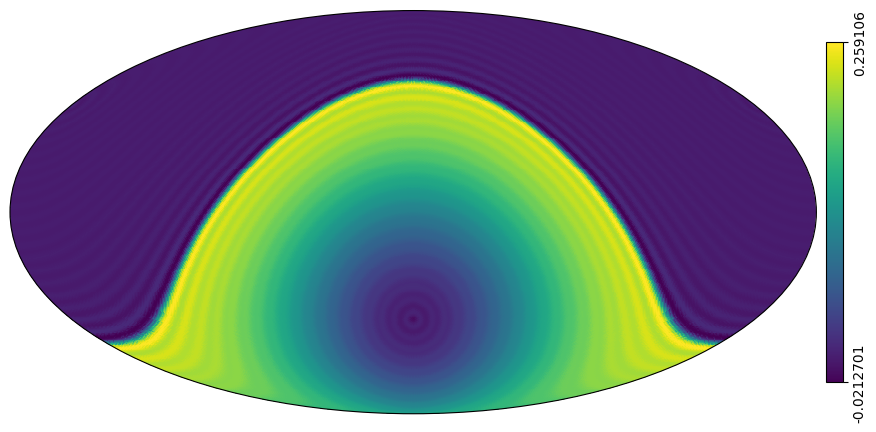

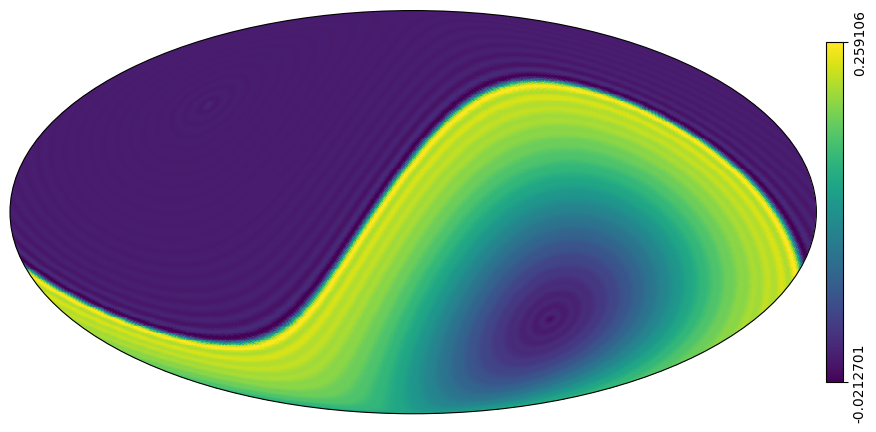

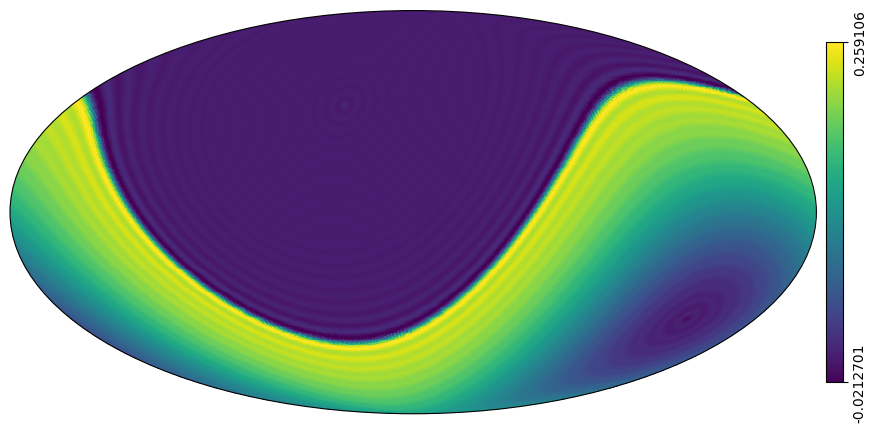

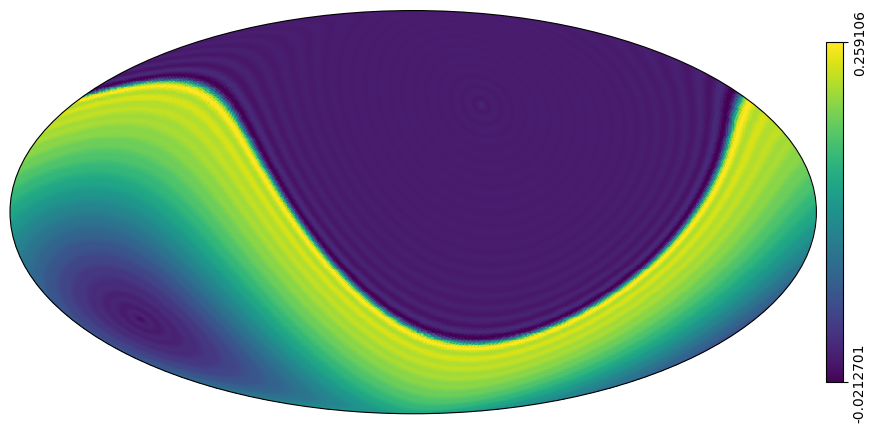

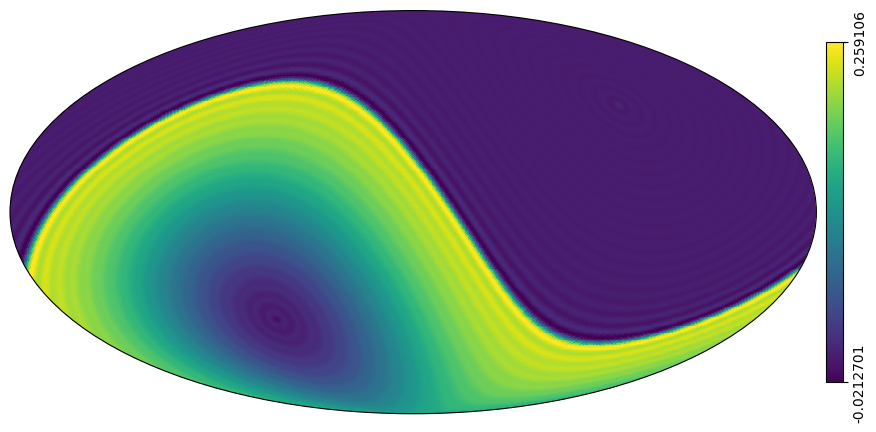

In [9]:
nplot = 5
for i in range(nplot):
    index = i * ntimes // nplot
    a = A[index, :hp.Alm.getsize(sim.lmax)]
    hp.projview(hp.alm2map(a, NSIDE), cbar=True, cb_orientation="vertical")
plt.show()

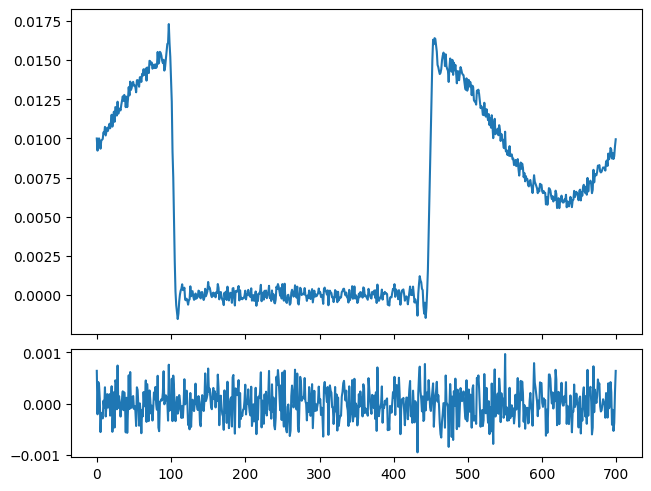

In [10]:
fig, axs = plt.subplots(nrows=2, sharex=True, gridspec_kw={"height_ratios":[3, 1]}, constrained_layout=True)
axs[0].plot(y)
axs[1].plot(noise)
plt.show()

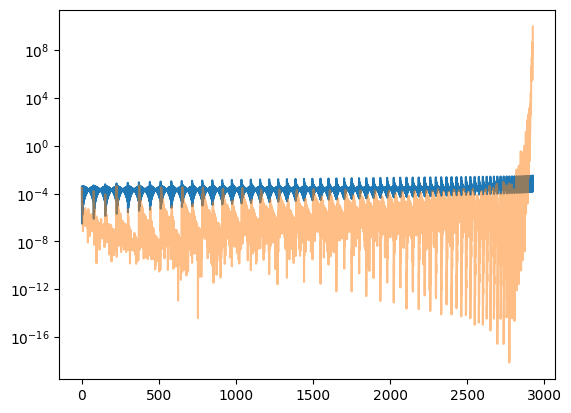

[  77 2847 2859 2870 2878 2879 2880 2886 2887 2888 2889 2893 2894 2895
 2896 2897 2899 2901 2902 2903 2904 2905 2906 2907 2908 2909 2910 2911
 2912 2913 2914 2915 2916 2917 2918 2919 2920 2921 2922 2923 2924 2925]


In [11]:
plt.figure()
plt.plot(np.abs(sim.sky.alm)**2)
plt.plot(np.abs(x_est)**2, alpha=.5)
plt.yscale("log")
#plt.ylim(1e3, 1e9)
#plt.xlim(2500)
plt.show()

print(np.argwhere(np.abs(x_est)**2 / np.abs(sim.sky.alm)**2 > 100)[:, 0])

In [12]:
ix = 2800
x_est = hp_alm(res, lmax=lmax)
x_est[ix:] = 0
print(hp.Alm.getlm(lmax, ix))

(70, 60)


In [13]:
map_true = hp.alm2map(sim.sky.alm, NSIDE)
map_est = hp.alm2map(x_est, NSIDE)

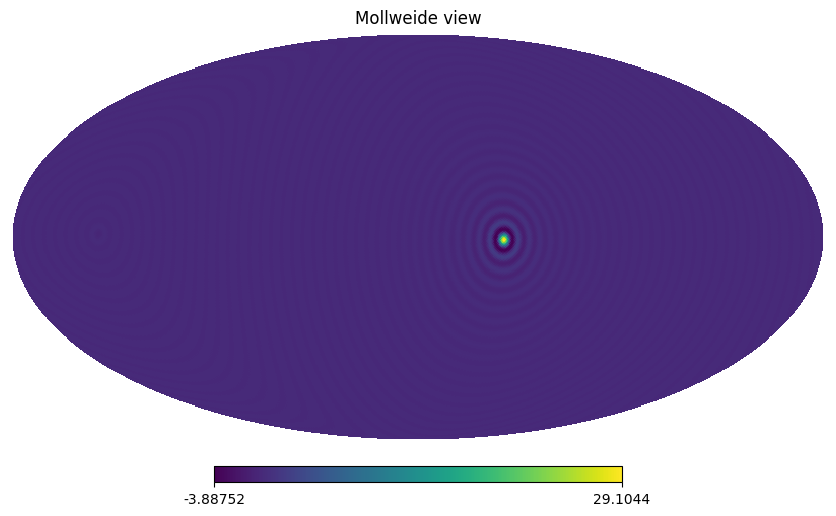

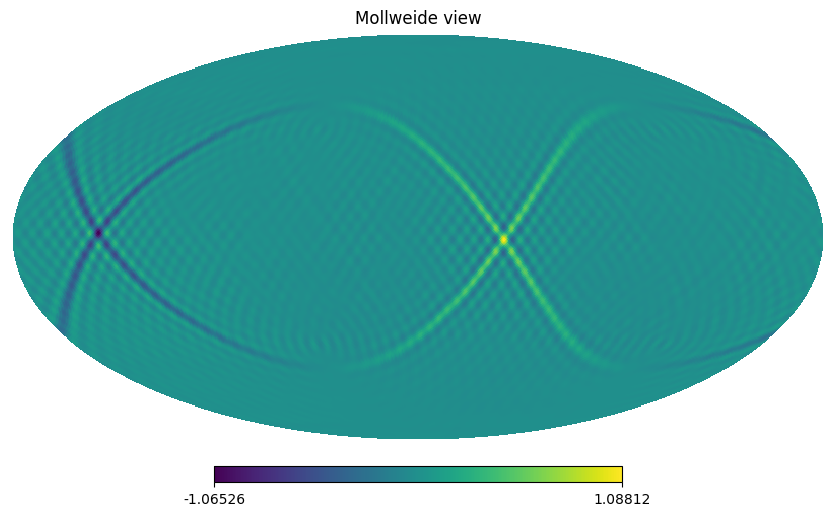

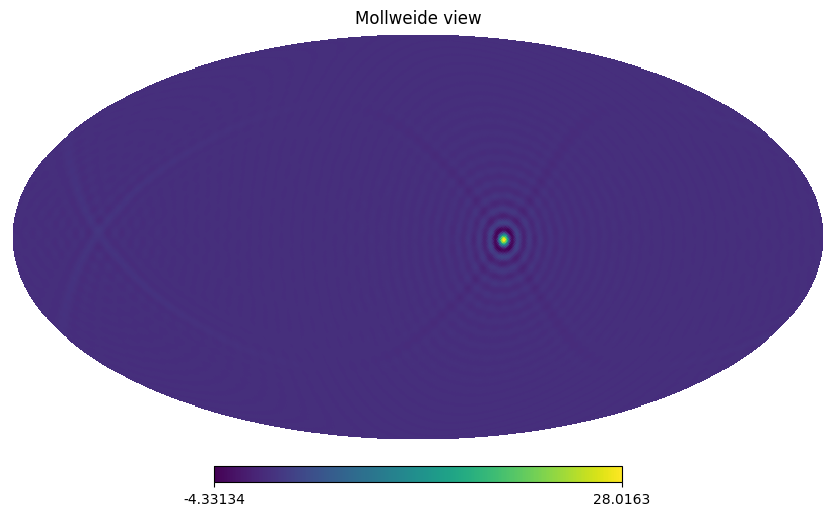

In [14]:
hp.mollview(map_true)
hp.mollview(map_est)
hp.mollview(map_true - map_est)

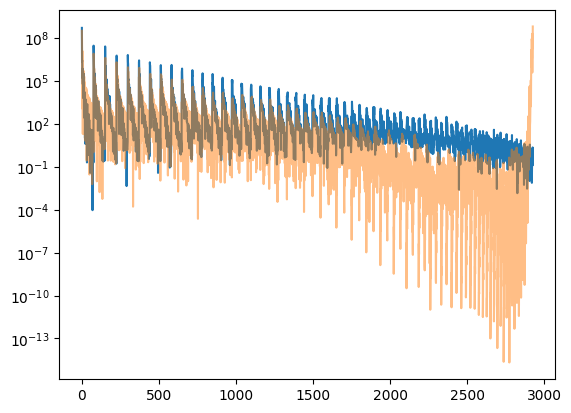

[  15   23   29   33   37   45   47   51   53   55   57   61   66   69
   73   75  134  138  142  146  208  210  224  241  257  271  281  290
  293  331  355  359  367  369  414  418  424  428  432  438  440  494
  500  504  506  510  549  555  570  571  575  577  629  641  702  708
  712  714  766  843  899  960  962  966 1022 1085 1089 1135 1192 1291
 1375 1440 2446 2692 2889 2897 2901 2902 2903 2904 2908 2909 2910 2911
 2912 2913 2914 2915 2916 2917 2918 2919 2920 2921 2922 2923 2924 2925]


In [15]:
# gsm
sky = cro.Sky.gsm(beam.frequencies, lmax=lmax)
sim = cro.Simulator(beam, sky, lmax=lmax, world=world, location=location, times=times)
A, x, W, noise = estimate_x(sim, method="pinv")
y = np.real(A @ x) + noise
res = W @ y
x_est = hp_alm(res, lmax=lmax)

plt.figure()
plt.plot(np.abs(sim.sky.alm)**2)
plt.plot(np.abs(x_est)**2, alpha=.5)
plt.yscale("log")
#plt.ylim(1e3, 1e9)
#plt.xlim(2500)
plt.show()

print(np.argwhere(np.abs(x_est)**2 / np.abs(sim.sky.alm)**2 > 100)[:, 0])

(70, 60)


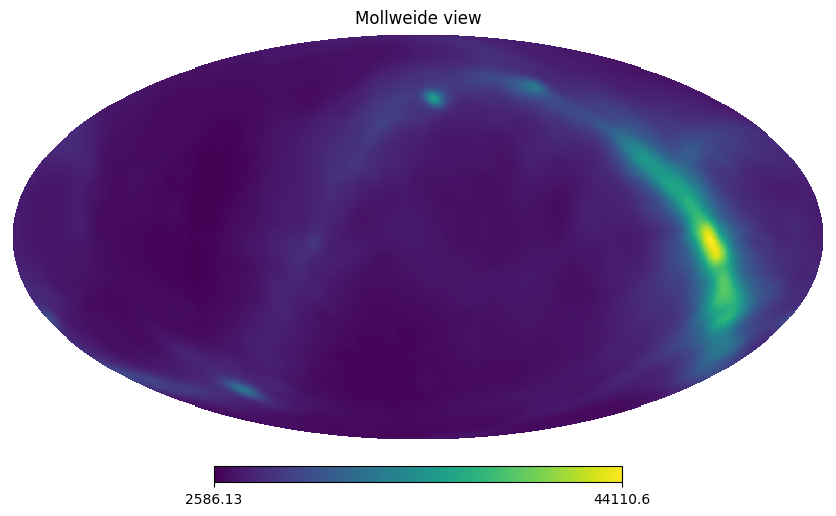

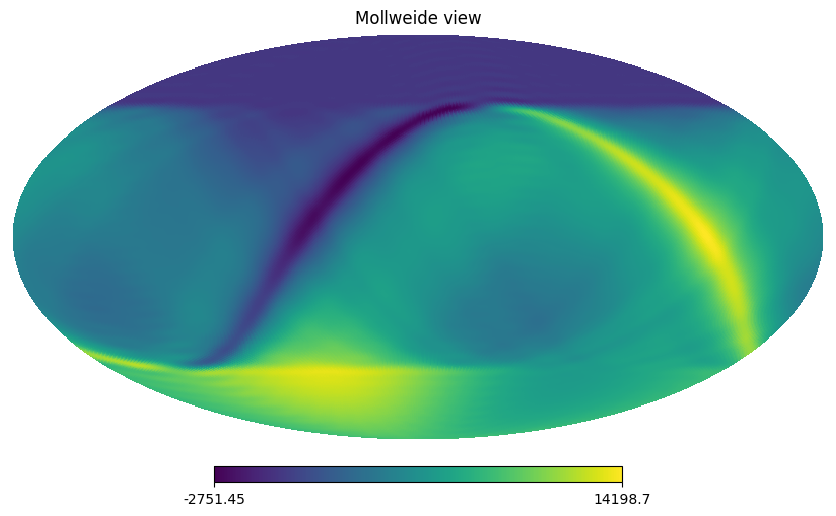

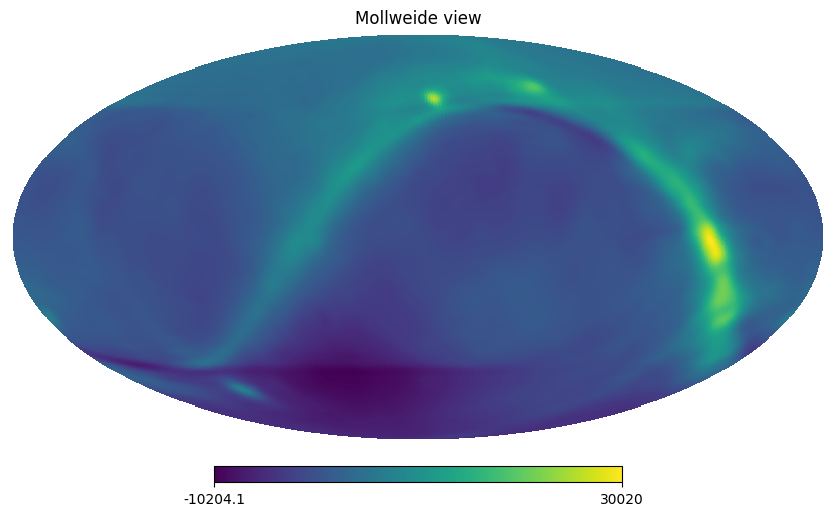

In [16]:
ix = 2800
x_est = hp_alm(res, lmax=lmax)
x_est[ix:] = 0
print(hp.Alm.getlm(lmax, ix))

map_true = hp.alm2map(sim.sky.alm, NSIDE)
map_est = hp.alm2map(x_est, NSIDE)

hp.mollview(map_true)
hp.mollview(map_est)
hp.mollview(map_true - map_est)